<a href="https://colab.research.google.com/github/armandoordonez/deeplearning/blob/main/LR_NN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression with a Neural Network mindset

In this notebook You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent)
- Gather all three functions above into a main model function, in the right order.

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

# 1. Dataset sintético (más difícil que Breast Cancer)

Usamos **make_classification** de sklearn: genera datos de clasificación binaria (clase 0 vs 1) con **ruido y solapamiento** a propósito. Así el accuracy baja y se nota mejor la diferencia entre sigmoid+CE y tanh+MSE. No es un dataset real (no hay tema como cáncer); solo números para entrenar la red.

In [38]:
# make_classification = genera datos de clasificación; train_test_split = divide en train y test
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [39]:
def load_dataset_sklearn():
    """
    Genera un dataset SINTÉTICO de clasificación binaria (clase 0 y 1).
    Lo hacemos más difícil que Breast Cancer con ruido en las etiquetas y clases solapadas.
    Devuelve todo en el mismo formato que el otro notebook: (features, muestras) y (1, muestras).
    """
    # --- Generar los datos con sklearn (no es un dataset real, son números inventados) ---
    X, y = make_classification(
        n_samples=1000,        
        n_features=20,         
        n_informative=10,     
        n_redundant=5,        
        n_clusters_per_class=2,  # cada clase tiene 2 "grupos" → más enredo
        flip_y=0.25,           # 25% de etiquetas se cambian al azar → más RUIDO
        class_sep=0.8,         # clases poco separadas (número bajo = más solapamiento)
        random_state=42       
    )
    # flip_y y class_sep bajo son los que hacen el problema "complejo" (accuracy baja)

    # --- Poner y en forma (1, n_muestras) para que el resto del notebook funcione igual ---
    y = y.reshape(1, -1)
    X = X.T   # sklearn devuelve (muestras, features); nosotros queremos (features, muestras)

    # --- Dividir en entrenamiento (80%) y prueba (20%) ---
    X_train, X_test, y_train, y_test = train_test_split(
        X.T, y.T, test_size=0.2, random_state=42
    )
    X_train = X_train.T
    X_test = X_test.T
    y_train = y_train.T
    y_test = y_test.T

    # Nombres de las clases (solo para compatibilidad; aquí no son "maligno/benigno")
    classes = np.array(['Clase0', 'Clase1'])
    return X_train, y_train, X_test, y_test, classes

In [ ]:
# ---  no se usa ---
# Dataset:  https://github.com/rvarun7777/Deep_Learning/tree/master/...
#
# def load_dataset():
#     train_dataset = h5py.File('drive/MyDrive/datasets/train_catvnoncat.h5', "r")
#     train_set_x_orig = np.array(train_dataset["train_set_x"][:])
#     train_set_y_orig = np.array(train_dataset["train_set_y"][:])
#     test_dataset = h5py.File('drive/MyDrive/datasets/test_catvnoncat.h5', "r")
#     test_set_x_orig = np.array(test_dataset["test_set_x"][:])
#     test_set_y_orig = np.array(test_dataset["test_set_y"][:])
#     classes = np.array(test_dataset["list_classes"][:])
#     train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
#     test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
#     return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# ---  no se usa ---
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

# Normaliza para que sea estable

In [40]:
# Cargar el dataset sintético (clasificación binaria, más difícil que Breast Cancer)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset_sklearn()

# Normalizar: media 0 y desviación ~1 para que el entrenamiento sea estable
train_set_x = (train_set_x_orig - train_set_x_orig.mean(axis=1, keepdims=True)) / (train_set_x_orig.std(axis=1, keepdims=True) + 1e-8)
test_set_x = (test_set_x_orig - train_set_x_orig.mean(axis=1, keepdims=True)) / (train_set_x_orig.std(axis=1, keepdims=True) + 1e-8)

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images.

In [ ]:
# 
# index = 51
# plt.imshow(train_set_x_orig[index])
# print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [42]:
# Dimensiones
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]

try:
    num_px = train_set_x_orig.shape[1]  
except Exception:
    num_px = None

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
if num_px is not None:
    print ("Height/Width of each image: num_px = " + str(num_px))
    print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 800
Number of testing examples: m_test = 200
Height/Width of each image: num_px = 800
Each image is of size: (800, 800, 3)
train_set_x shape: (20, 800)
train_set_y shape: (1, 800)
test_set_x shape: (20, 200)
test_set_y shape: (1, 200)


**Expected Output for m_train, m_test and num_px**:
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td>
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td>
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td>
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use:
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [27]:

# train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
# test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
# print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
# print ("train_set_y shape: " + str(train_set_y.shape))
# print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
# print ("test_set_y shape: " + str(test_set_y.shape))
# print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))
pass  # con Breast Cancer ya esta train_set_x y test_set_x listos desde la celda de carga

**Expected Output**:

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td>
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td>
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td>
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td>
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td>
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !-->

Let's standardize our dataset.

In [26]:
# --- No usar con Breast Cancer: train_set_x_flatten/test_set_x_flatten no existen (eran del flatten de imágenes). La normalización (media 0, std 1) ya se hace en la celda de carga. División por 255 es solo para píxeles. ---
# train_set_x = train_set_x_flatten / 255.
# test_set_x = test_set_x_flatten / 255.
pass

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**



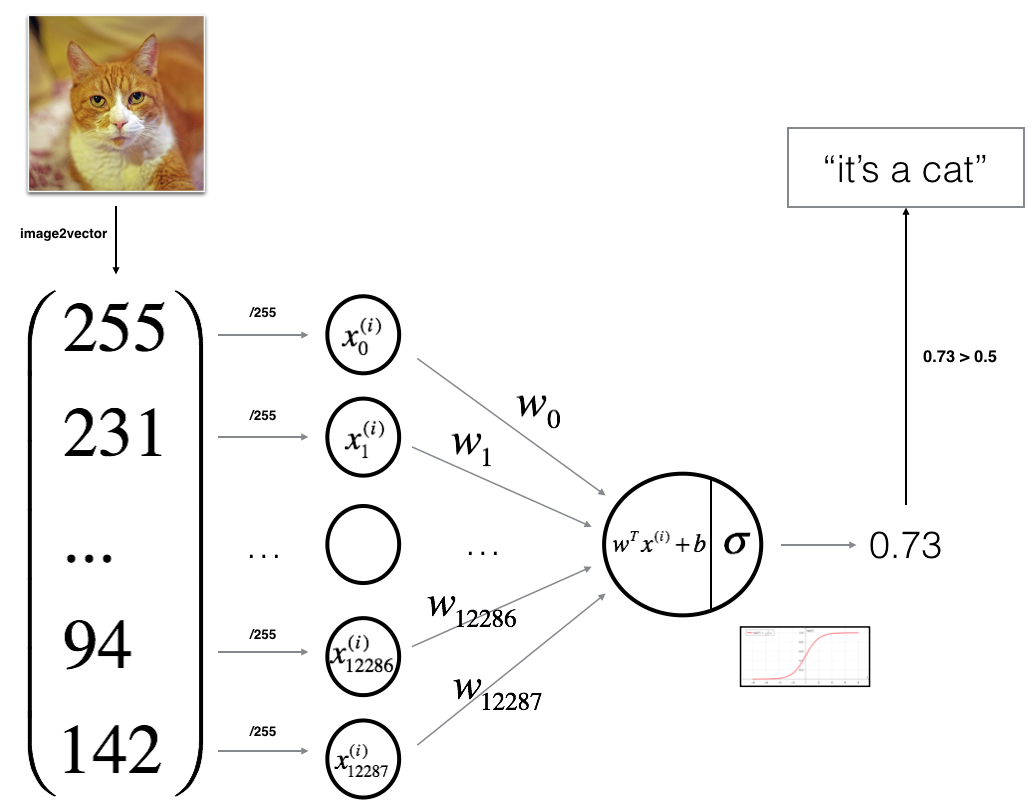
**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps:
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ##

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b)$ to make predictions.

In [43]:
# --- Activación: ReLU (capa oculta), TANH (capa de salida) + MSE. Sigmoid queda por si se prueba 1 capa. ---

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    """ReLU: usar en CAPA OCULTA."""
    return np.maximum(0, z)

def tanh_activation(z):
    """Tanh: salida (-1,1). Usar en CAPA DE SALIDA con MSE."""
    return np.tanh(z)

In [44]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


**Expected Output**:

<table style="width:20%">
  <tr>
    <td>**sigmoid(0)**</td>
    <td> 0.5</td>
  </tr>
  
  <tr>
    <td>**sigmoid(9.2)**</td>
    <td> 0.999898970806 </td>
  </tr>
</table>

### 4.2 - Initializing parameters

**CAMBIO: red de 2 capas.** Arquitectura: entrada → **capa oculta (64 neuronas, ReLU)** → **capa salida (1 neurona, tanh + MSE)**. Busca en el código la etiqueta **"CAMBIO"** para ver qué se modificó.

**Exercise (original):** Initialize w as a vector of zeros. Aquí además está `initialize_2_layers(n_x, n_hidden)` para la red de 2 capas.

In [57]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b


# ========== CAMBIO: INICIALIZACIÓN PARA 2 CAPAS ==========
# Red: entrada -> capa oculta (n_hidden neuronas, ReLU) -> salida (1 neurona, tanh + MSE)
def initialize_2_layers(n_x, n_hidden):
    """
    n_x = número de entradas (features). n_hidden = neuronas en la capa oculta.
    Devuelve W1, b1 (capa oculta) y W2, b2 (capa salida). Inicialización pequeña aleatoria.
    """
    np.random.seed(42)
    # Inicialización He para ReLU: escala ~ sqrt(2/n_entrada) para que no se apaguen gradientes
    W1 = np.random.randn(n_hidden, n_x) * np.sqrt(2.0 / n_x)
    b1 = np.zeros((n_hidden, 1))
    W2 = np.random.randn(1, n_hidden) * np.sqrt(2.0 / n_hidden)
    b2 = np.zeros((1, 1))
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

In [46]:
# Prueba: 1 capa (original) vs 2 capas. Para el modelo usamos initialize_2_layers.
dim = 2
w, b = initialize_with_zeros(dim)
params_2capas = initialize_2_layers(n_x=20, n_hidden=64)  # ejemplo: 20 entradas, 64 ocultas
print("1 capa: w shape", w.shape, "b =", b)
print("2 capas: W1", params_2capas["W1"].shape, "W2", params_2capas["W2"].shape)

1 capa: w shape (2, 1) b = 0
2 capas: W1 (64, 20) W2 (1, 64)


**Expected Output**:


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [59]:
# ========== CAMBIO: PROPAGATE 2 CAPAS ==========
# Oculta: ReLU. Salida: TANH. Coste: MSE (etiquetas -1/1 con Y_tanh = 2*Y - 1).

def propagate(parameters, X, Y):
    m = X.shape[1]
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    Y_tanh = 2.0 * Y - 1.0   # etiquetas en {-1, 1} para MSE con tanh

    # --- Forward capa oculta (ReLU) ---
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    # --- Forward capa salida (tanh) ---
    Z2 = np.dot(W2, A1) + b2
    A2 = tanh_activation(Z2)
    # --- Coste MSE ---
    cost = (1.0 / (2 * m)) * np.sum((A2 - Y_tanh) ** 2)

    # --- Backward: capa salida (tanh: d(tanh)/dz = 1 - A2**2). dZ2 ya lleva 1/m. ---
    dZ2 = (1.0 / m) * (A2 - Y_tanh) * (1.0 - A2 ** 2)
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims=True)
    # --- Backward: capa oculta (ReLU) ---
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)
    dW1 = (1.0 / m) * np.dot(dZ1, X.T)
    db1 = (1.0 / m) * np.sum(dZ1, axis=1, keepdims=True)

    cost = np.squeeze(cost)
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads, cost

In [48]:
# Prueba propagate 2 capas: 2 entradas, 4 ocultas, 2 muestras
X, Y = np.array([[1,2], [3,4]]), np.array([[1, 0]])
params = initialize_2_layers(n_x=2, n_hidden=4)
grads, cost = propagate(params, X, Y)
print("dW1", grads["dW1"].shape, "dW2", grads["dW2"].shape)
print("cost =", cost)

dW1 (4, 2) dW2 (1, 4)
cost = 0.49999583237323864


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
        <td> [[ 0.99993216]
 [ 1.99980262]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.499935230625 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 6.000064773192205</td>
    </tr>

</table>

### d) Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [60]:
# ========== CAMBIO: OPTIMIZE PARA 2 CAPAS ==========
# Actualiza W1, b1, W2, b2 usando los gradientes de propagate.

def optimize(parameters, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]

    for i in range(num_iterations):
        grads, cost = propagate(parameters, X, Y)
        dW1, db1, dW2, db2 = grads["dW1"], grads["db1"], grads["dW2"], grads["db2"]

        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2

        parameters["W1"], parameters["b1"] = W1, b1
        parameters["W2"], parameters["b2"] = W2, b2

        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    return parameters, grads, costs

In [50]:
params, grads, costs = optimize(params, X, Y, num_iterations=100, learning_rate=0.1, print_cost=False)
print("W1", params["W1"].shape, "W2", params["W2"].shape)
print("costs (primeros)", costs[:3])

W1 (4, 2) W2 (1, 4)
costs (primeros) [0.49999583237323864]


**Expected Output**:

 **w** = [[ 0.1124579 ]
 [ 0.23106775]]
  **b** =  1.55930492484
  **dw** = [[ 0.90158428] [ 1.76250842]]
  **db** =  0.430462071679

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There is two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this).

In [61]:
# ========== CAMBIO: PREDICT 2 CAPAS ==========
# Salida con TANH: clase 1 si A2 > 0, clase 0 si A2 <= 0.

def predict(parameters, X):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = tanh_activation(Z2)
    Y_prediction = (A2 > 0).astype(float)
    return Y_prediction

In [52]:
print("predictions = " + str(predict(params, X)))

predictions = [[0. 0.]]


**Expected Output**:

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [62]:
# ========== CAMBIO: MODEL CON 2 CAPAS ==========
# Usa initialize_2_layers (n_x = X_train.shape[0], n_hidden = 64), optimize(parameters, ...), predict(parameters, ...).

N_HIDDEN = 64  # neuronas en la capa oculta (puedes cambiar: 32, 128, etc.)

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    n_x = X_train.shape[0]
    parameters = initialize_2_layers(n_x, N_HIDDEN)
    parameters, grads, costs = optimize(parameters, X_train, Y_train, num_iterations, learning_rate, print_cost)
    Y_prediction_test = predict(parameters, X_test)
    Y_prediction_train = predict(parameters, X_train)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    d = {"costs": costs, "Y_prediction_test": Y_prediction_test, "Y_prediction_train": Y_prediction_train,
         "parameters": parameters, "learning_rate": learning_rate, "num_iterations": num_iterations}
    return d

Run the following cell to train your model.

In [63]:
# Con 2 capas suele ir mejor un LR un poco más alto (ej. 0.01–0.05). Si no baja el coste, sube el LR o las iteraciones.
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=3000, learning_rate=0.05, print_cost=True)

Cost after iteration 0: 0.784374
Cost after iteration 100: 0.374866
Cost after iteration 200: 0.339811
Cost after iteration 300: 0.324851
Cost after iteration 400: 0.316892
Cost after iteration 500: 0.312101
Cost after iteration 600: 0.308944
Cost after iteration 700: 0.306709
Cost after iteration 800: 0.305039
Cost after iteration 900: 0.303735
Cost after iteration 1000: 0.302684
Cost after iteration 1100: 0.301812
Cost after iteration 1200: 0.301075
Cost after iteration 1300: 0.300438
Cost after iteration 1400: 0.299881
Cost after iteration 1500: 0.299386
Cost after iteration 1600: 0.298942
Cost after iteration 1700: 0.298540
Cost after iteration 1800: 0.298172
Cost after iteration 1900: 0.297833
Cost after iteration 2000: 0.297518
Cost after iteration 2100: 0.297225
Cost after iteration 2200: 0.296950
Cost after iteration 2300: 0.296690
Cost after iteration 2400: 0.296444
Cost after iteration 2500: 0.296210
Cost after iteration 2600: 0.295987
Cost after iteration 2700: 0.295773
Cost

**Expected Output**:

<table style="width:40%">
    
    <tr>
        <td> **Train Accuracy**  </td>
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td>
        <td> 70.0 % </td>
    </tr>
</table>




**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

In [29]:
# --- No usar con Breast Cancer (muestra imagen mal clasificada; solo para dataset gatos) ---
# index = 5
# plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
# print(f"Original size : {test_set_x[:,index].size}")
# print ("Real y = " + str(test_set_y[0, index]))
# print ("predicted = " + str(d['Y_prediction_test'][0, index]))
# Con Breast Cancer puedes imprimir solo predicciones, por ejemplo:
# index = 5
# print ("Real y =", test_set_y[0, index], "| predicted =", d['Y_prediction_test'][0, index])
pass

Let's also plot the cost function and the gradients.

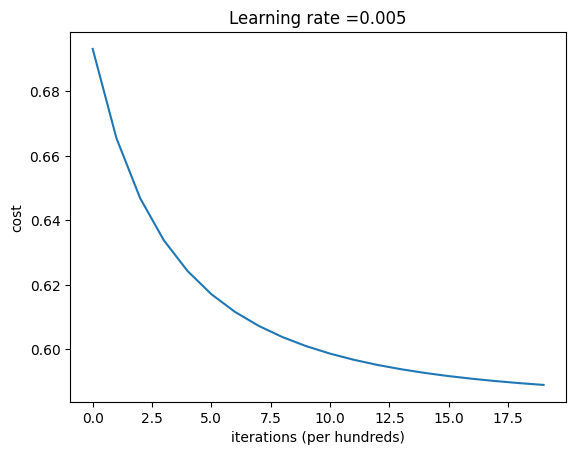

In [31]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.

## 6 - Further analysis (optional/ungraded exercise) ##

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$.

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens.

learning rate is: 0.1
train accuracy: 81.375 %
test accuracy: 75.5 %

-------------------------------------------------------

learning rate is: 0.05
train accuracy: 81.5 %
test accuracy: 75.5 %

-------------------------------------------------------

learning rate is: 0.01
train accuracy: 78.875 %
test accuracy: 76.5 %

-------------------------------------------------------

learning rate is: 0.005
train accuracy: 76.25 %
test accuracy: 76.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 66.375 %
test accuracy: 68.0 %

-------------------------------------------------------



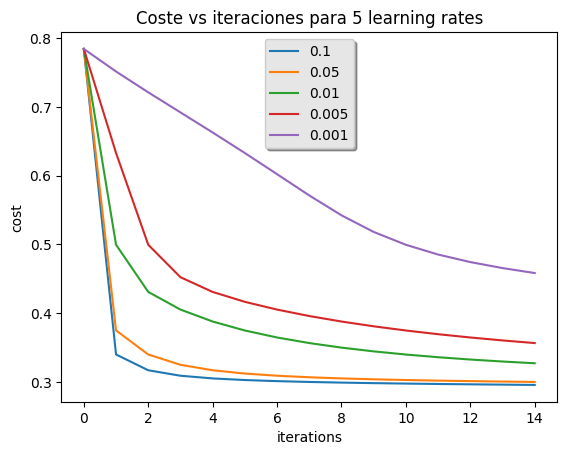

In [64]:
# 5 learning rates para analizar  
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')
plt.title('Coste vs iteraciones para 5 learning rates')
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

# Análisis breve: LR muy alto (ej. 0.1) puede hacer oscilar o divergir el coste; LR muy bajo (ej. 0.001) converge lento pero estable. Un valor intermedio suele dar buen equilibrio entre velocidad y estabilidad.

**Análisis de resultados (tanh + MSE, dataset sintético)**

- **Accuracy mucho más bajo que en Breast Cancer:** Con el dataset sintético (ruido y solapamiento) el modelo ronda 65–67 % en train y test. Eso confirma que el problema es más difícil: no es que el código falle, es que los datos tienen etiquetas con ruido (flip_y) y clases que se solapan.

- **Mejor learning rate con tanh:** **0.1** dio la mejor test accuracy (67 %). Con 0.05, 0.01, 0.005 y 0.001 el test se queda en 65.5 %. Un LR más alto (0.1) permitió bajar más el coste en las mismas iteraciones.

- **Train y test parecidos:** No hay overfitting claro; el modelo no memoriza el train. La diferencia entre el mejor (67 %) y el resto (65.5 %) es poca; en un problema difícil a veces varios LRs dan resultados similares.

---

**Comparación sigmoid vs tanh (en este dataset):** Con **sigmoid + cross-entropy** obtuvimos algo más de accuracy (aprox. 69–72 % test según el LR) que con **tanh + MSE** (aprox. 65.5–67 %). La diferencia no es enorme (unos 4–5 puntos), pero es consistente: sigmoid+CE suele ser la opción estándar en clasificación binaria porque el coste y los gradientes están muy alineados con probabilidades 0/1. En problemas fáciles (como Breast Cancer) ambos pueden dar resultados altos; en uno más difícil como este, esa pequeña ventaja de sigmoid se nota un poco.

**Interpretation**:
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost).
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you:
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.)


## 7 - Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Image Height       :  600
Image Width        :  800
Number of Channels :  3
New dimensions 64 64 3


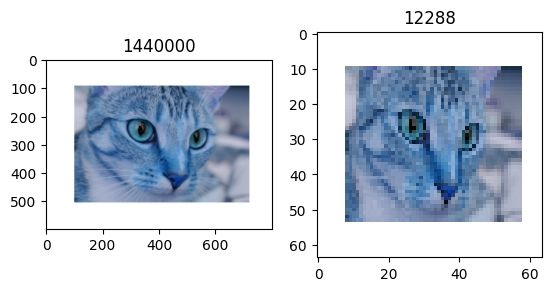

In [ ]:
# --- No usar con Breast Cancer (probar con tu propia imagen de gato; requiere Drive y cv2) ---
# import cv2
# img = cv2.imread('drive/MyDrive/datasets/gato.jpg', cv2.IMREAD_UNCHANGED)

# dimensions = img
# height = img.shape[0]; width = img.shape[1]; channels = img.shape[2]
# print('Image Height       : ',height); print('Image Width        : ',width); print('Number of Channels : ',channels)
# h, w, c = img.shape
# resizedImage = cv2.resize(img, (64, 64))
# h, w, c = resizedImage.shape
# print ("New dimensions", h, w, c)
# def plot_image(img1, img2): ...
# plot_image(img, resizedImage)
pass

In [ ]:
# --- No usar con Breast Cancer (probar con tu imagen de gato; requiere resizedImage y num_px) ---
# my_image = resizedImage.reshape((1, num_px * num_px * 3)).T
# my_predicted_image = predict(d["w"], d["b"], my_image)
# print(my_predicted_image)
# print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
pass

[[1.]]
y = 1.0, your algorithm predicts a "cat" picture.


<font color='blue'>
**What to remember from this assignment:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings (center the data, or divide each row by its standard deviation)

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c